# Riddle me this 1 - Stochastic simulation

author: [ahartikainen](https://github.com/ahartikainen) (github)


See riddle in here
## Undersampled Radio ep.33
https://youtu.be/tdk7X26aw7I?t=48m45s

Solution is based on random sampling on probability distributions (instead of point estimates).

Uncertainties are addressed with distributions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Avogadro
from scipy import stats as st
%matplotlib inline
plt.style.use('fivethirtyeight')
from numbers import Number

# Define some helper functions (numpy compliant)

In [2]:
def radius_to_volume(r):
    # Approximate earth (oblate spheroid) with a sphere
    return 4/3 * r**3

In [3]:
# basic stuff

def volume_to_mass(v, rho):
    return v * rho

def mass_to_volume(m, rho):
    return m / rho

def density(m, v):
    return m / v

In [4]:
# print value if number else descriptive stats

def print_desc(sample, n=3):
    if isinstance(sample, Number):
        msg = "value: {:.{n}g}".format(sample, n=n)
    else:
        msg = "mean: {:.{n}g}\nstd: {:.{n}g}\nmin: {:.{n}g}\nmax: {:.{n}g}".format(sample.mean(), 
                                                                                   sample.std(), 
                                                                                   sample.min(), 
                                                                                   sample.max(), n=n)
    print(msg)

In [5]:
# if number
#     skip
# else 
#     plot histogram (full data)
#     plot kde (subsample if n is given else full data)

def plot_sample(sample, n=None):
    if isinstance(sample, Number):
        return
    plt.hist(sample, normed=True, bins=20)
    x = np.linspace(*plt.gca().get_xlim(), 1000)
    if n is not None:
        sample = np.random.choice(sample, size=int(n))
    kde = st.gaussian_kde(sample)
    y = kde.pdf(x)
    plt.plot(x, y, lw=3)

# Number of random samples

In [6]:
n = int(1e6) 

# Earth radius estimates

Rough point estimates are taken from wikipedia

## Earth radius (total)

mean: 6371
std: 1.998
min: 6362
max: 6380


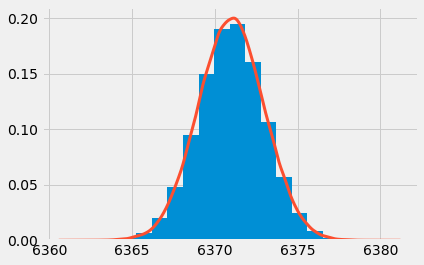

In [7]:
# Wikipedia: Mean radius 6371.0 km
r_earth = st.norm(loc=6371, scale=2).rvs(n) * 1000
print_desc(r_earth/1000, 4)
plot_sample(r_earth/1000, n=1e5)

## Core

mean: 3486
std: 0.9994
min: 3481
max: 3491


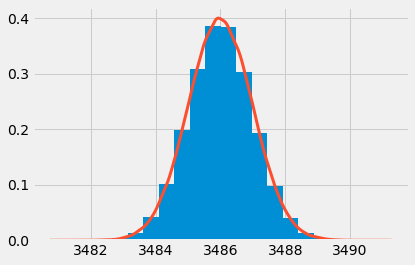

In [8]:
# Wikipedia: Outer core 2260, Inner core 1210 
# typo in my calculations for outer core 
r_core = st.norm(loc=(1216 + 2270), scale=1).rvs(n) * 1000 # m
print_desc(r_core/1000, 4)
plot_sample(r_core/1000, n=1e5)

## Crust (oceanic)

mean: 7.998
std: 1.791
min: 2.136
max: 19.04


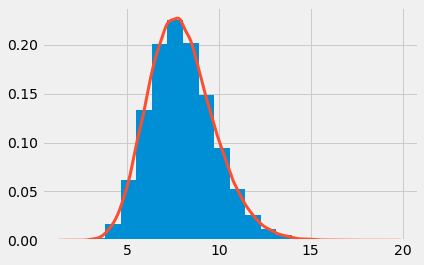

In [9]:
# From 5 to 10 km 
# probably overestimating this one
# Use of gamma distribution due to better support near 0: 0 to inf
oceanic_crust_proportion = 0.6 # point estimate -> keeping simulation in 1D
r_crust_oceanic = st.gamma(a=20, loc=0, scale=0.4).rvs(int(oceanic_crust_proportion*n)) * 1000
print_desc(r_crust_oceanic/1000, 4)
plot_sample(r_crust_oceanic/1000, n=1e5)

## Crust (continental)

mean: 38
std: 12.01
min: 5.796
max: 121.3


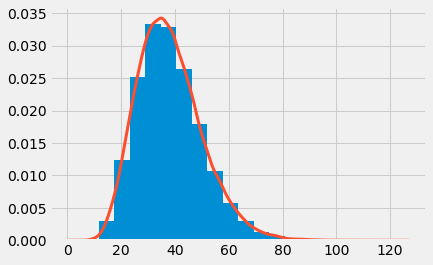

In [10]:
# from 25 to 70 km
r_crust_continental = st.gamma(10, loc=0, scale=3.8).rvs(n-int(oceanic_crust_proportion*n)) * 1000
print_desc(r_crust_continental/1000, 4)
plot_sample(r_crust_continental/1000, n=1e5)

## Crust combined

mean: 20
std: 16.61
min: 2.136
max: 121.3


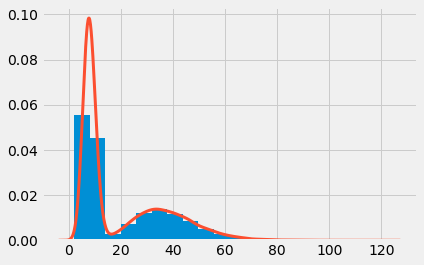

In [11]:
r_crust = np.concatenate([r_crust_oceanic, r_crust_continental])
print_desc(r_crust/1000, 4)
plot_sample(r_crust/1000, n=1e5)

## Mantle

mean: 2865
std: 16.75
min: 2764
max: 2889


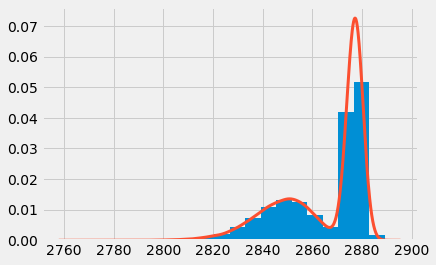

In [12]:
# Wikipedia: 2886 km
# Underestimating this value
r_mantle = r_earth - r_core - r_crust #st.norm(loc=2885, scale=10).rvs(n) * 1000 #m

print_desc(r_mantle/1000, 4)
plot_sample(r_mantle/1000, n=1e5)

## Mantle + core

In [13]:
r_core_mantle = r_core + r_mantle

# Mantle composition

## Molar mass

mean: 0.167
std: 0.0478
min: 0.0237
max: 0.442


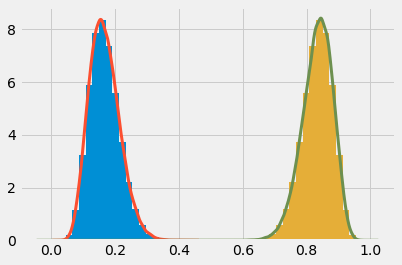

In [14]:
# Assume that olivine is mixture of forsterite and fayalite
fe_concentration = st.distributions.beta(a=1*10,b=5*10).rvs(n)
mg_concentration = 1 - fe_concentration

print_desc(fe_concentration) # kg/mol
plot_sample(fe_concentration, n=1e5)
plot_sample(mg_concentration, n=1e5)

mean: 0.122
std: 0.00151
min: 0.117
max: 0.13


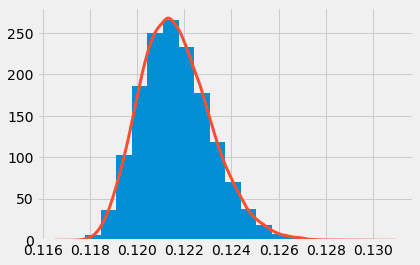

In [15]:
# molar mass
molar_mass_Fe = 55.845 # g/mol
molar_mass_Mg = 24.305 # g/mol
molar_mass_Si = 28.0855 # g/mol
molar_mass_O = 15.9994 # g/mol

molar_mass_FeMgSiO4 = molar_mass_Fe * fe_concentration + \
                      molar_mass_Mg * mg_concentration + \
                      molar_mass_Si + \
                      molar_mass_O * 4

molar_mass_FeMgSiO4_kg = molar_mass_FeMgSiO4 / 1000

print_desc(molar_mass_FeMgSiO4_kg) # kg/mol
plot_sample(molar_mass_FeMgSiO4_kg, n=1e5)

## Density

ref. https://progearthplanetsci.springeropen.com/articles/10.1186/s40645-016-0089-2

mean: 3407
std: 56.47
min: 3238
max: 3732


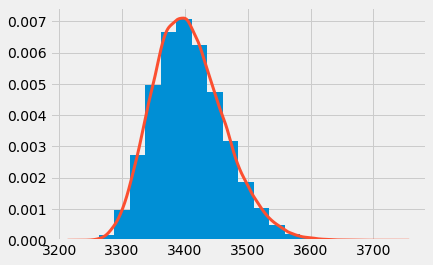

In [16]:
# Somewhere internet:  3270 - 3370
# Overestimating this for olivine, but there is always bridgmanite+periclase in lower mantle
# (with estimated density 4000-6000)
# see ref.
density_mantle = 3210*mg_concentration + 4392*fe_concentration # kg/m
print_desc(density_mantle, 4)
plot_sample(density_mantle, n=1e5)

## Volume

mean: 2.85e+20
std: 2.69e+18
min: 2.69e+20
max: 2.89e+20


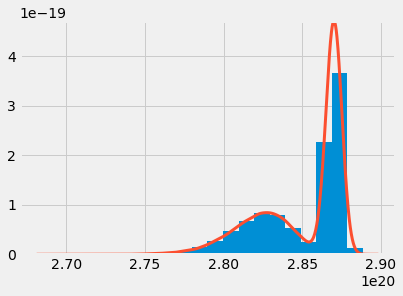

In [17]:
# Calculate mantle volume with core volume and mantle+core volume
volume_core = radius_to_volume(r_core)
volume_mantle_core = radius_to_volume(r_core_mantle)

volume_mantle = volume_mantle_core - volume_core  # m^3

print_desc(volume_mantle)
plot_sample(volume_mantle, n=1e5)

## Mass

mean: 9.71e+23
std: 1.85e+22
min: 8.94e+23
max: 1.07e+24


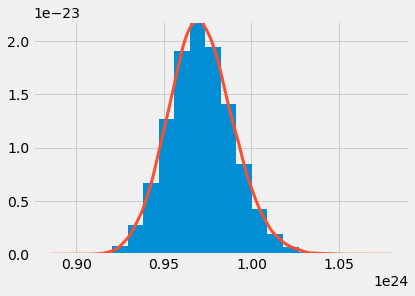

In [18]:
mass_mantle = volume_to_mass(volume_mantle, density_mantle) # kg
print_desc(mass_mantle)
plot_sample(mass_mantle, n=1e5)

## Moles

mean: 7.98e+24
std: 8.24e+22
min: 7.49e+24
max: 8.23e+24


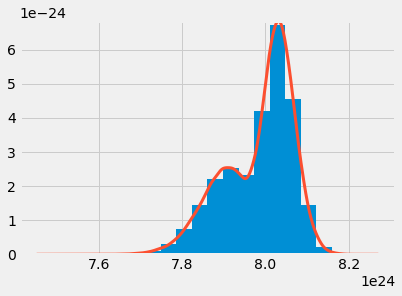

In [19]:
moles_mantle = mass_mantle / molar_mass_FeMgSiO4_kg

print_desc(moles_mantle) # mol
plot_sample(moles_mantle, n=1e5)

## Number of molecules

ref. https://en.wikipedia.org/wiki/Avogadro_constant

mean: 4.81e+48
std: 4.96e+46
min: 4.51e+48
max: 4.96e+48


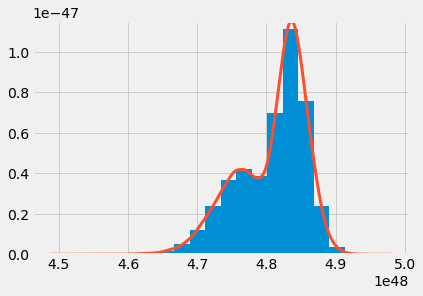

In [20]:
molecules_mantle = moles_mantle * Avogadro

print_desc(molecules_mantle)
plot_sample(molecules_mantle, n=1e5)

# Sample

## Volume (sample)

In [21]:
volume_sample = 1/1000 # 1 l = 1 dm^3 = 0.001 m^3
volume_sample # m^3

0.001

In [22]:
# Known value
fe_concentration_sample = 1/6
mg_concentration_sample = 1-fe_concentration_sample

In [23]:
# molar mass
molar_mass_Fe = 55.845 # g/mol
molar_mass_Mg = 24.305 # g/mol
# From podcast
molar_mass_Mg_star = 28.5 # g/mol
molar_mass_Si = 28.0855 # g/mol
molar_mass_O = 15.9994 # g/mol

molar_mass_FeMg_star_SiO4 = molar_mass_Fe * fe_concentration_sample + \
                            molar_mass_Mg_star * mg_concentration_sample + \
                            molar_mass_Si + \
                            molar_mass_O * 4
            
molar_mass_FeMg_star_SiO4_kg = molar_mass_FeMg_star_SiO4 / 1000

print_desc(molar_mass_FeMg_star_SiO4_kg) # kg/mol
plot_sample(molar_mass_FeMg_star_SiO4_kg, n=1e5)

value: 0.125


## Density (sample)

In [24]:
density_sample = 3210*mg_concentration_sample + 4392*fe_concentration_sample

print_desc(density_sample, 4) # kg/m^3
plot_sample(density_sample, n=1e5)

value: 3407


## Mass (sample)

In [25]:
mass_sample = volume_to_mass(volume_sample, density_sample)

print_desc(mass_sample, 4) # kg
plot_sample(mass_sample, n=1e5)

value: 3.407


## Moles (sample)

In [26]:
moles_sample = mass_sample / molar_mass_FeMg_star_SiO4_kg

print_desc(moles_sample) # mol
plot_sample(moles_sample, n=1e5)


value: 27.2


## Molecules (sample)

In [27]:
molecules_sample = moles_sample * Avogadro

print_desc(molecules_sample)
plot_sample(molecules_sample, n=1e5)

value: 1.64e+25


# Concentration

## Uniform distribution of sample molecules in mantle

Assume here that sample is evenly distributed: mean value can be estimated

mean: 3.41e-24
std: 3.55e-26
min: 3.31e-24
max: 3.64e-24


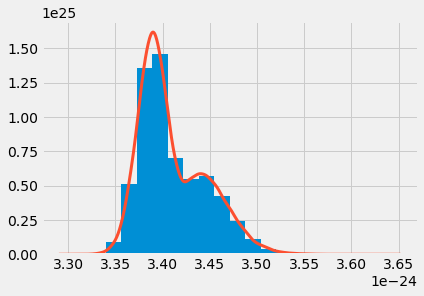

In [28]:
# assume that molecules_sample << molecules_mantle
concentration_sample_in_mantle = molecules_sample / molecules_mantle

print_desc(concentration_sample_in_mantle) # molecule/m^3
plot_sample(concentration_sample_in_mantle, n=1e5)

## Mass (new sample)

mean: 3.407
std: 0.05647
min: 3.238
max: 3.732


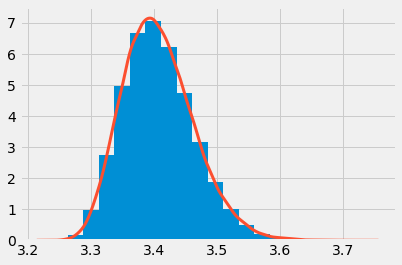

In [29]:
mass_new_sample = volume_to_mass(volume_sample, density_mantle)
print_desc(mass_new_sample, 4) # kg
plot_sample(mass_new_sample, n=1e5)

## Moles (new sample)

mean: 28
std: 0.117
min: 27.6
max: 28.6


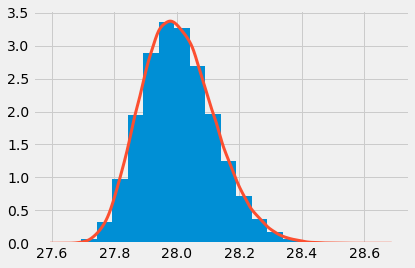

In [30]:
moles_new_sample = mass_new_sample / molar_mass_FeMgSiO4_kg

print_desc(moles_new_sample) # mol
plot_sample(moles_new_sample, n=1e5)

## Molecules (new sample)

mean: 1.69e+25
std: 7.03e+22
min: 1.66e+25
max: 1.72e+25


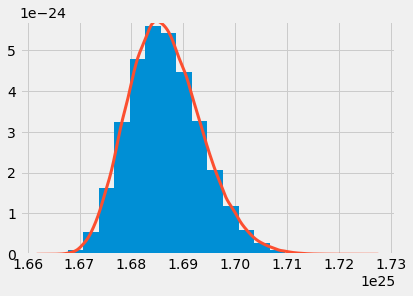

In [31]:
molecules_new_sample = moles_new_sample * Avogadro

print_desc(molecules_new_sample)
plot_sample(molecules_new_sample, n=1e5)

# Expected number of molecules

mean: 57.5
std: 0.548
min: 56.8
max: 60.9


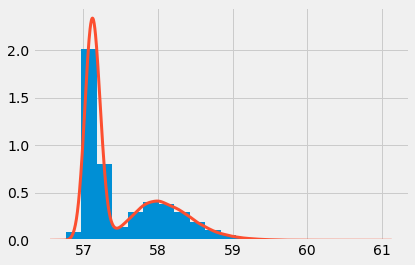

In [32]:
number_of_expected_molecules_in_new_sample = molecules_new_sample * concentration_sample_in_mantle

print_desc(number_of_expected_molecules_in_new_sample)
plot_sample(number_of_expected_molecules_in_new_sample, n=1e5)

In [33]:
# Round values to integer
CI_95 = (np.percentile(number_of_expected_molecules_in_new_sample, 2.5),
        np.percentile(number_of_expected_molecules_in_new_sample, 97.5))

In [34]:
print("Expected number of molecules in new sample: {:.0f}".format(number_of_expected_molecules_in_new_sample.mean()))
print("CI: [{:.0f}, {:.0f}]".format(np.floor(CI_95[0]), np.ceil(CI_95[1])))

Expected number of molecules in new sample: 58
CI: [56, 59]


# Probability for one or more molecules in sample

assume that molecules are distributed exponentially with mean value `== number_of_expected_molecules_in_new_sample`

mean theta: 0.0174
mean: 0.9828
std: 0.0001613
min: 0.9825
max: 0.9837


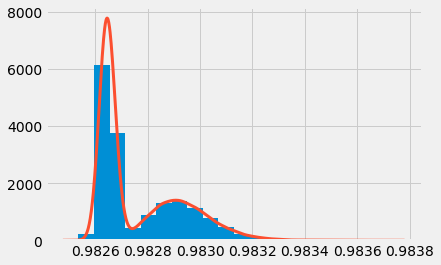

In [35]:
theta = 1/number_of_expected_molecules_in_new_sample

# scale = 1/theta = number_of_expected_molecules_in_new_sample
# sf = survival function = 1 - cdf
atleast_one_molecule_in_sample = st.distributions.expon(scale=number_of_expected_molecules_in_new_sample).sf(1)

print("mean theta: {:.3g}".format(theta.mean()))
print_desc(atleast_one_molecule_in_sample, 4)
plot_sample(atleast_one_molecule_in_sample, n=1e5)